## Obtengo y Preparo Datos 

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import KFold

In [5]:
df = pd.read_csv('bank-full.csv', sep = ";")

In [6]:
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no


In [7]:
df.shape

(45211, 17)

In [8]:
columns = ['age','job','marital','education','balance','housing','contact','day','month','duration','campaign','pdays','previous',
'poutcome','y']

In [9]:
df_0 = df

In [10]:
df_0.shape

(45211, 17)

In [11]:
df = df[columns]

In [12]:
df.shape

(45211, 15)

In [13]:
df.head(2)

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no


In [14]:
## Transformo el target "y"

df['y'] = df['y'].str.replace('yes','1')
df['y'] = df['y'].str.replace('no','0')

/tmp/ipykernel_27424/3193916728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = df['y'].str.replace('yes','1')
/tmp/ipykernel_27424/3193916728.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = df['y'].str.replace('no','0')


In [15]:
df['y'] = df['y'].astype(int)

/tmp/ipykernel_27424/3666938844.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = df['y'].astype(int)


In [16]:
df.dtypes

age           int64
job          object
marital      object
education    object
balance       int64
housing      object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object

## Divido el dataset

In [17]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_test), len(df_val)

(27126, 9043, 9042)

In [18]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [19]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [20]:
del df_train['y']
del df_val['y']
del df_test['y']

### Question 1

In [21]:
from sklearn.metrics import roc_auc_score

In [22]:
numerical = list(df_train.dtypes[df_train.dtypes == 'int64'].index)

In [23]:
numerical

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [24]:
auc = roc_auc_score(y_train,df_train.balance)

In [25]:
auc

0.5888313805382317

In [26]:
for n in numerical:
    auc = roc_auc_score(y_train,df_train[n])

    print (n, auc)

age 0.48781428247265596
balance 0.5888313805382317
day 0.474042117616092
duration 0.8147002759670778
campaign 0.42854569843178414
pdays 0.5901276247352144
previous 0.5985653242764153


RTA 1: duration

### Question 2

In [27]:
dicts = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)
 
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [28]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
## y_pred = model.predict(X_val)

In [29]:
auc = roc_auc_score(y_val,y_pred)
auc

0.9004159581551736

RTA2: Es 0.69 --- Ahora me da 0.9, pero antes me daba otro valor

Check, si uso model.predict me da 0.69; si uso model_predict_proba me da 0.9

### Question 3: Precision and Recall

In [30]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [31]:
scores = []

thresholds = np.linspace(0,1,101)

for t in thresholds:
    actual_positive = (y_val ==1)
    actual_negative = (y_val == 0)

    predict_positive = y_pred >= t
    predict_negative = y_pred < t

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    fpr = fp/(tn+fp)
    tpr = tp/(tp+fn)

    scores.append((t, tp,tn,fp,fn,fpr,tpr))

In [32]:
columns = ['umbral','tp','tn','fp','fn','fpr','tpr']
df_scores = pd.DataFrame(scores,columns=columns)
df_scores

,umbral,tp,tn,fp,fn,fpr,tpr
0,0.00,1098,0,7944,0,1.000000,1.000000
1,0.01,1094,940,7004,4,0.881672,0.996357
2,0.02,1093,2155,5789,5,0.728726,0.995446
3,0.03,1087,3199,4745,11,0.597306,0.989982
4,0.04,1068,4144,3800,30,0.478348,0.972678
...,...,...,...,...,...,...,...
96,0.96,30,7927,17,1068,0.002140,0.027322
97,0.97,25,7929,15,1073,0.001888,0.022769
98,0.98,21,7934,10,1077,0.001259,0.019126
99,0.99,11,7939,5,1087,0.000629,0.010018


In [33]:
df_scores['precision']=df_scores.tp/(df_scores.tp + df_scores.fp)

In [34]:
df_scores['recall']=df_scores.tp/(df_scores.tp + df_scores.fn)

In [35]:
df_scores[::10]

,umbral,tp,tn,fp,fn,fpr,tpr,precision,recall
0,0.0,1098,0,7944,0,1.000000,1.000000,0.121433,1.000000
10,0.1,926,6451,1493,172,0.187941,0.843352,0.382803,0.843352
20,0.2,712,7251,693,386,0.087236,0.648452,0.506762,0.648452
30,0.3,566,7537,407,532,0.051234,0.515483,0.581706,0.515483
40,0.4,462,7672,272,636,0.034240,0.420765,0.629428,0.420765
50,0.5,373,7752,192,725,0.024169,0.339709,0.660177,0.339709
60,0.6,290,7807,137,808,0.017246,0.264117,0.679157,0.264117
70,0.7,225,7843,101,873,0.012714,0.204918,0.690184,0.204918
80,0.8,148,7877,67,950,0.008434,0.134791,0.688372,0.134791
90,0.9,76,7917,27,1022,0.003399,0.069217,0.737864,0.069217


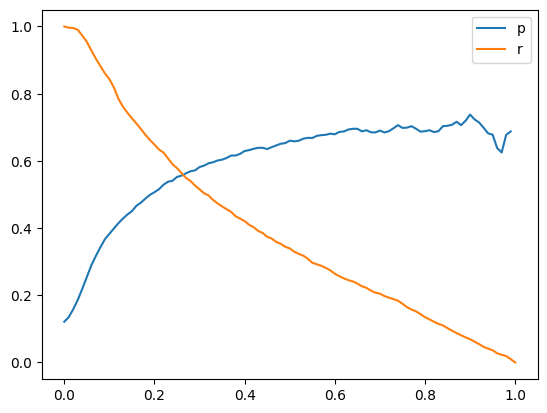

In [36]:
plt.plot(df_scores.umbral, df_scores.precision, label = 'p')
plt.plot(df_scores.umbral, df_scores.recall, label = 'r')
plt.legend()

RTA3: Se cruzan en 0.265

### Question 4: F1 score

In [37]:
df_scores['F1']= ((df_scores.precision * df_scores.recall)/(df_scores.precision + df_scores.recall))*2

In [38]:
df_scores[df_scores.F1 == df_scores.F1.max()]

,umbral,tp,tn,fp,fn,fpr,tpr,precision,recall,F1
22,0.22,686,7333,611,412,0.076913,0.624772,0.528913,0.624772,0.57286


RTA 4: es 0.22 

### Question 5: 5-Fold CV

In [39]:
categorical = list(df_train.dtypes[df_train.dtypes == 'object'].index)

In [40]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
 
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
 
    return dv, model

In [41]:
dv, model = train(df_train, y_train)

In [42]:
def predict(df, dv, model):
     dicts = df[categorical + numerical].to_dict(orient='records')
 
     X = dv.fit_transform(dicts)
     y_pred = model.predict_proba(X)[:,1]
 
     return y_pred

In [43]:
y_pred = predict(df_val, dv, model)

In [44]:
## Entonces, iteramos:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
scores = []
 
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
 
    y_train = df_train.y.values
    y_val = df_val.y.values
 
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [45]:
scores

[0.8901424851269238,
 0.9077028479275602,
 0.9045355630284982,
 0.8948818818154812,
 0.9190294379578012,
 0.9030994815655385,
 0.9117472033111731,
 0.9045718615812073,
 0.9084884988151705,
 0.9153439041384553]

In [46]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.906 +- 0.008


RTA 5: es 0.006

### Question 6: Hyperparameter Tuning

In [47]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
 
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
 
    return dv, model

In [48]:
dv, model = train(df_train, y_train, C=10)

In [49]:
def predict(df, dv, model):
     dicts = df[categorical + numerical].to_dict(orient='records')
 
     X = dv.fit_transform(dicts)
     y_pred = model.predict_proba(X)[:,1]
 
     return y_pred

In [50]:
y_pred = predict(df_val, dv, model)

In [51]:
## Entonces, iteramos:

n_splits = 5

for C in [0.000001, 0.001, 1]:

    scores = []

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state =1)
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.y.values
        y_val = df_val.y.values
    
        dv,model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
                    
    print('C=%s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))   

C=1e-06, 0.701 +- 0.009
C=0.001, 0.861 +- 0.007
C=1, 0.906 +- 0.006


RTA 6: es 1